### Pedalcast: Predicting daily bike usage for each station - Cleaning Notebook

#### Data Sources

This project uses two main datasets:

- **BlueBikes Trip Data**  
  Historical trip records from Boston's BlueBikes system, including start/end stations, timestamps, and bike types. The data used in this project spans **July 2023 through June 2025**.

  📂 Source: [BlueBikes Open Data Portal](https://s3.amazonaws.com/hubway-data/index.html)


- **Weather Data**  
  Daily weather conditions (temperature, precipitation, wind, visibility, etc.) for the Boston area, aligned with each ride day.  
  
  📂 Source: [Visual Crossing Weather](https://www.visualcrossing.com/weather-data)

These datasets are combined to train a model that predicts daily bike demand at the station level.

### Imports

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from glob import glob

##### Combining Monthly Trip Data

In the cell below, we load and combine all monthly BlueBikes trip data files into a single DataFrame.

Each monthly dataset is stored as a CSV file named in the format:  
`YYYY-MM-bluebikes-tripdata.csv` inside the `data/` directory.

We use `glob` to match all relevant files, then read them into pandas DataFrames.  

In [42]:
csv_files = sorted(glob("data/*-bluebikes-tripdata.csv"))

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        dfs.append(df)
    except Exception as e:
        print(f"❌ Failed to load {f}: {e}")

if dfs:
    trips = pd.concat(dfs, ignore_index=True)
    print(f"✅ Combined shape: {trips.shape}")
else:
    print("❌ No CSVs loaded. Check filename pattern or folder.")

✅ Combined shape: (8793350, 13)


We keep only the columns needed for daily station-level analysis:  
`started_at`, `start_station_name`, and `start_station_id`.

2033 rows are dropped due to missing start_station_id, and a `date` column is created by extracting the day from the `started_at` timestamp and converting it to a datetime object.

In [43]:
relevant_cols = ['started_at','start_station_name','start_station_id']
trips = trips[relevant_cols]
trips=trips.dropna()
trips['date'] = pd.to_datetime(pd.to_datetime(trips['started_at'],format='mixed').dt.date)
trips

,started_at,start_station_name,start_station_id,date
0,2023-07-18 13:48:34,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-18
1,2023-07-19 12:16:30,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-19
2,2023-07-28 17:49:26,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-28
3,2023-07-22 23:14:17,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-22
4,2023-07-21 18:41:22,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-21
...,...,...,...,...
8793345,2025-06-12 20:20:45.355,Tremont St at Northampton St,C32056,2025-06-12
8793346,2025-06-25 17:13:30.010,Park Street T Stop - Tremont St at Park St,B32068,2025-06-25
8793347,2025-06-09 16:03:20.398,Innovation Lab - 125 Western Ave at Batten Way,A32011,2025-06-09
8793348,2025-06-03 09:22:41.353,Centre St at Seaverns Ave,E32008,2025-06-03


We first filter the trip data to include only rides from **June 2025**.

Then, we extract the list of **stations that were active** (i.e., had trips) during that month.

Finally, we filter the full dataset to keep **only trips from those active stations**, ensuring consistency when forecasting or evaluating recent demand.

In [44]:
# Filter to June 2025 only
trips_may = trips[(trips['date'] >= '2025-06-01') & (trips['date'] <= '2025-06-30')]

# Get station IDs active in June 2025
active_stations = trips_may['start_station_id'].unique()
trips_active = trips[trips['start_station_id'].isin(active_stations)]
trips_active.head()

,started_at,start_station_name,start_station_id,date
0,2023-07-18 13:48:34,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-18
1,2023-07-19 12:16:30,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-19
2,2023-07-28 17:49:26,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-28
3,2023-07-22 23:14:17,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-22
4,2023-07-21 18:41:22,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,2023-07-21


In [45]:
daily_counts = (
    trips_active.groupby(['start_station_id', 'start_station_name', 'date'])
                .size()
                .reset_index(name='trip_count')
)
daily_counts.head()

,start_station_id,start_station_name,date,trip_count
0,A32000,Fan Pier,2023-07-01,30
1,A32000,Fan Pier,2023-07-02,20
2,A32000,Fan Pier,2023-07-03,28
3,A32000,Fan Pier,2023-07-04,35
4,A32000,Fan Pier,2023-07-05,41


In [55]:
weather = pd.read_csv('data/boston_weather.csv')
weather = weather[['datetime','temp','humidity','precip','snow','windspeed','visibility','cloudcover']]
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather =weather.rename({'datetime':'date'},axis=1)
weather.head()

,date,temp,humidity,precip,snow,windspeed,visibility,cloudcover
0,2023-06-30,21.5,82.3,0.000,0.0,22.0,15.4,48.3
1,2023-07-01,19.3,93.5,0.000,0.0,20.3,4.8,90.6
2,2023-07-02,20.9,89.9,8.278,0.0,28.9,7.6,98.5
3,2023-07-03,20.4,89.4,14.249,0.0,18.0,10.4,89.5
4,2023-07-04,20.1,94.4,12.163,0.0,16.4,12.0,96.0


In [56]:
daily_counts_w = daily_counts.merge(weather,on='date')
daily_counts_w.head(2)

,start_station_id,start_station_name,date,trip_count,temp,humidity,precip,snow,windspeed,visibility,cloudcover
0,A32000,Fan Pier,2023-07-01,30,19.3,93.5,0.000,0.0,20.3,4.8,90.6
1,A32000,Fan Pier,2023-07-02,20,20.9,89.9,8.278,0.0,28.9,7.6,98.5


In [57]:
daily_counts_w.to_csv("data/daily_counts_with_weather.csv", index=False)

#### EDA

##### Distribution of Target Variable

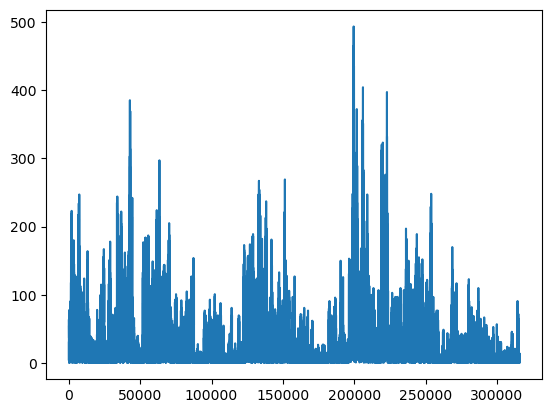

In [49]:
daily_counts_w['trip_count'].plot();

##### Top 10 Most Used Stations

In [50]:
daily_counts_w.groupby('start_station_name')['trip_count'].sum().sort_values(ascending=False)[:10]

start_station_name
MIT at Mass Ave / Amherst St                                   168000
Central Square at Mass Ave / Essex St                          129261
Harvard Square at Mass Ave/ Dunster                            115211
MIT Vassar St                                                   96871
MIT Pacific St at Purrington St                                 93428
Charles Circle - Charles St at Cambridge St                     88383
Ames St at Main St                                              85390
Christian Science Plaza - Massachusetts Ave at Westland Ave     78519
Mass Ave/Lafayette Square                                       76627
Beacon St at Massachusetts Ave                                  74384
Name: trip_count, dtype: int64

In [51]:
daily_counts_w.columns

Index(['start_station_id', 'start_station_name', 'date', 'trip_count', 'temp',
       'humidity', 'precip', 'snow', 'windspeed', 'visibility'],
      dtype='object')

#### Learning Relations between Weather Conditions and Bike Usage(Trip Count)

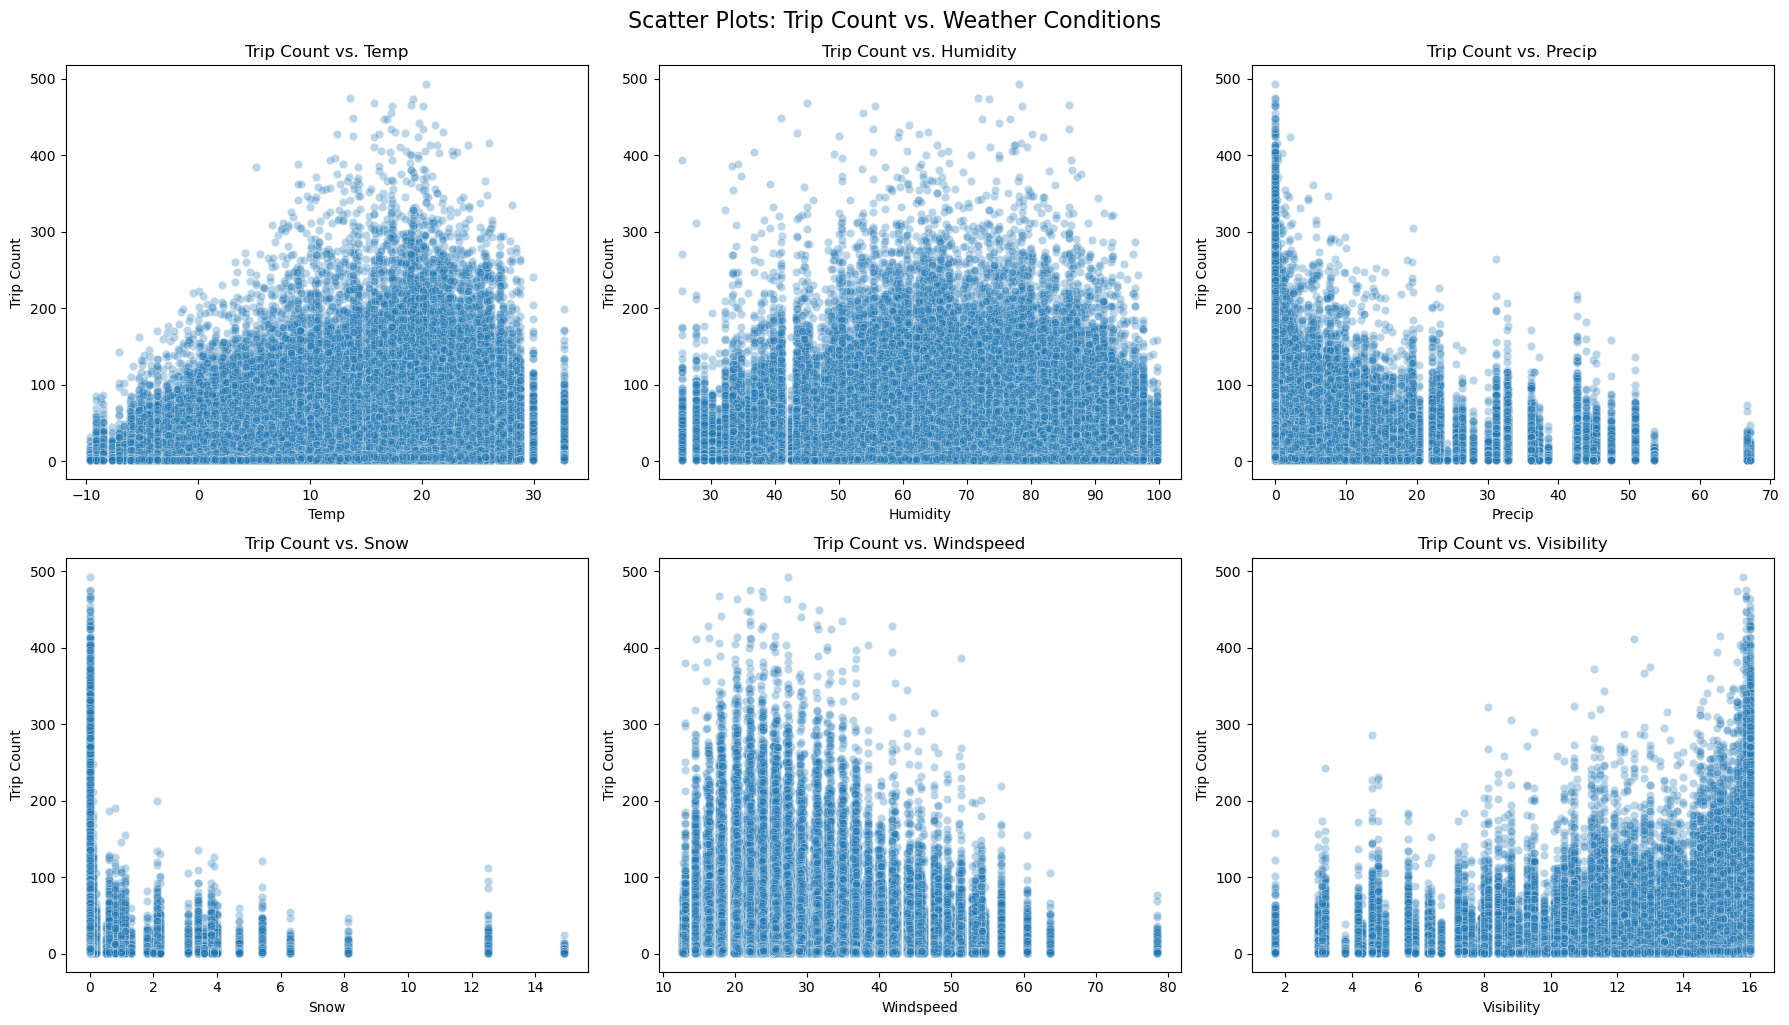

In [52]:

# List of weather features to compare
weather_vars = ['temp', 'humidity', 'precip', 'snow', 'windspeed', 'visibility']

# Set up figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    ax = axes[i]
    sns.scatterplot(
        data=daily_counts_w,
        x=var,
        y='trip_count',
        alpha=0.3,
        ax=ax
    )
    ax.set_title(f'Trip Count vs. {var.capitalize()}')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Trip Count')
plt.tight_layout()
plt.suptitle('Scatter Plots: Trip Count vs. Weather Conditions', fontsize=16, y=1.02)
plt.show()

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_98677/2631457080.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_98677/2631457080.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_98677/2631457080.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_98677/2631457080.py:15: UserWarning:

set_ticklabels() should only be used with a fixed 

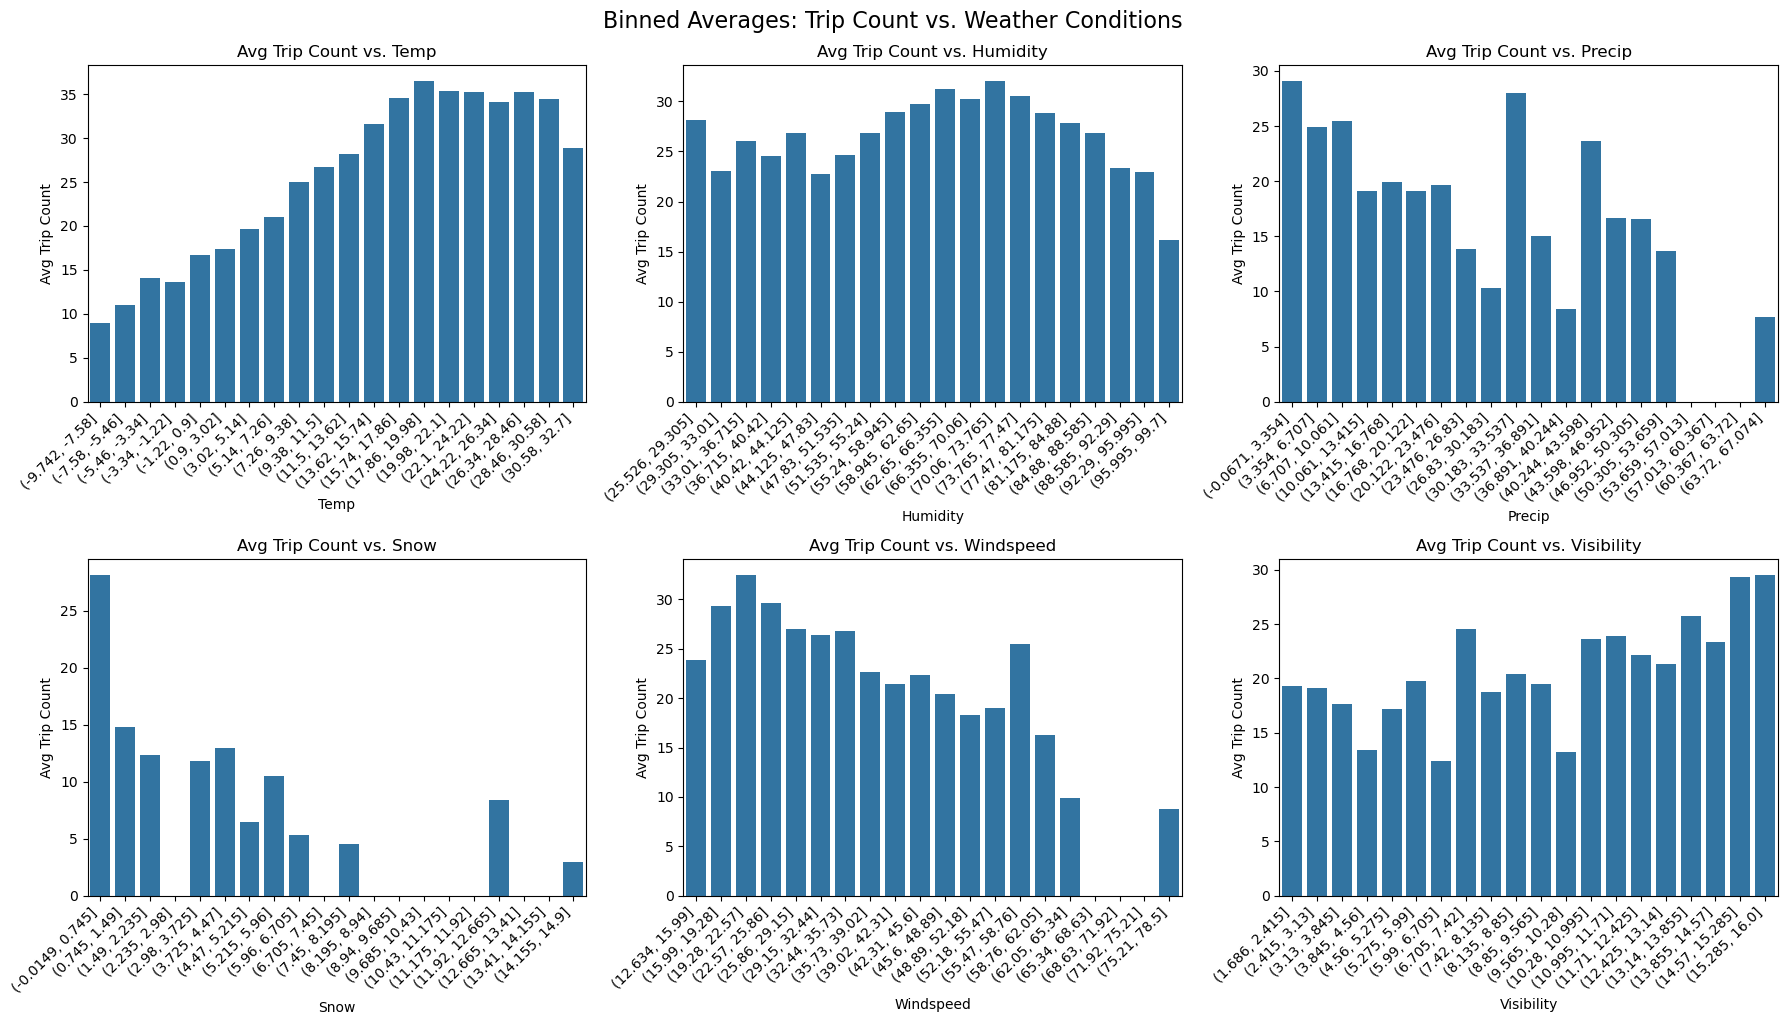

In [53]:
weather_vars = ['temp', 'humidity', 'precip', 'snow', 'windspeed', 'visibility']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    # Bin the variable
    daily_counts_w[f'{var}_bin'] = pd.cut(daily_counts_w[var], bins=20)
    grouped = daily_counts_w.groupby(f'{var}_bin')['trip_count'].mean().reset_index()

    # Plot
    ax = axes[i]
    sns.barplot(x=f'{var}_bin', y='trip_count', data=grouped, ax=ax)
    ax.set_title(f'Avg Trip Count vs. {var.capitalize()}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Avg Trip Count')
plt.tight_layout()
plt.suptitle('Binned Averages: Trip Count vs. Weather Conditions', fontsize=16, y=1.02)
plt.show()

We examine the relationship between daily trip counts and various weather variables using scatterplots and bar plots of binned averages. Below is a summary of the observed trends:

##### Temperature (`temp`)
- Strong positive trend: As temperature increases from below freezing to ~20°C, trip counts rise steadily.
- Plateaus or dips above ~25–30°C, possibly due to heat discomfort.
- Ideal range for biking appears to be 15–25°C.

##### Humidity (`humidity`)
- Bell-shaped pattern: peak bike usuage at humidity (~60–75%).
- Fewer trips at both very low (<40%) and very high (>90%) levels.

##### Precipitation (`precip`)
- Strong negative correlation: demand drops sharply as rain increases.
- Most trips occur at 0 mm precipitation.
- Negative Relationship

##### Snow (`snow`)
- Very low usage when any measurable snow is present.
- Negative Relationship

##### Windspeed (`windspeed`)
- General negative trend after 23 km/h wind speeds.

##### Visibility (`visibility`)
- Positive correlation: more trips on clear, high-visibility days (12–16 km).
- Low-visibility days (e.g., fog, storm) show less demand.
- Positive Relationship



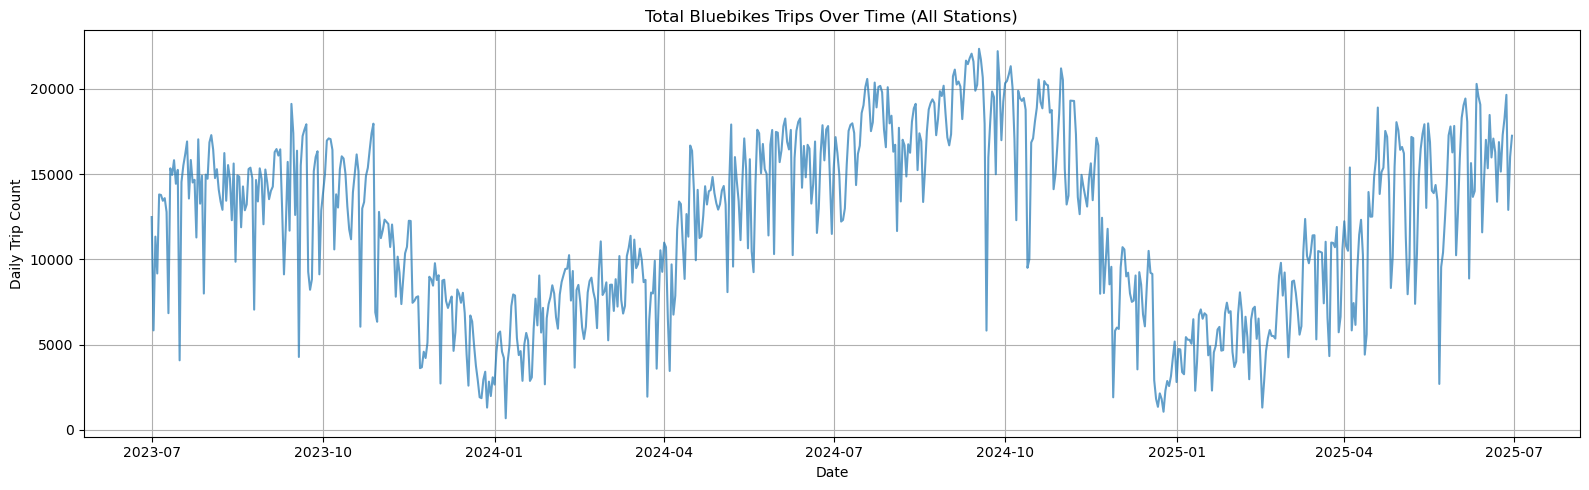

In [54]:
# Aggregate total trips per day across all stations
daily_total = daily_counts_w.groupby('date')['trip_count'].sum().reset_index()

# Plot
plt.figure(figsize=(16, 5))
plt.plot(daily_total['date'], daily_total['trip_count'], color='tab:blue', alpha=0.7)
plt.title("Total Bluebikes Trips Over Time (All Stations)")
plt.xlabel("Date")
plt.ylabel("Daily Trip Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# Group by date to get daily trip totals
daily_total = daily_counts_w.groupby('date')['trip_count'].sum().reset_index()

# Compute 7-day rolling average
daily_total['rolling_7'] = daily_total['trip_count'].rolling(7).mean()

# --- Plot 1: Raw Daily Trip Count ---
fig_daily = px.line(
    daily_total,
    x='date',
    y='trip_count',
    title='📊 Daily Bluebikes Trips Over Time',
    labels={'trip_count': 'Trip Count', 'date': 'Date'}
)
fig_daily.update_layout(template='plotly_white', hovermode='x unified')

# --- Plot 2: 7-Day Rolling Average ---
fig_rolling = px.line(
    daily_total,
    x='date',
    y='rolling_7',
    title='📈 7-Day Rolling Average of Bluebikes Trips',
    labels={'rolling_7': '7-Day Avg Trip Count', 'date': 'Date'}
)
fig_rolling.update_layout(template='plotly_white', hovermode='x unified')

# Show both
fig_daily.show()
fig_rolling.show()